# Imports

In [2]:
import pandas as pd; import seaborn as sb; import statsmodels.formula.api as smf; import pingouin;
from itertools import combinations; import os; from analysis_helpers import *; 
import scipy; from scipy import stats; import os; import math; import warnings
warnings.filterwarnings('ignore')

# Load and organize data

need to start with full_gaze because pres gaze already has means?


In [3]:
gaze  = pd.read_csv('../parsed_data/full_pres_gaze.csv')
behav = pd.read_csv('../parsed_data/full_behavioral.csv')

In [4]:
gaze_full = pd.read_csv('../parsed_data/full_gaze.csv')

In [5]:
# put data into centimeters
gaze['av_x_coord'] = gaze['av_x_coord']*(59.8/2048)
gaze['av_y_coord'] = gaze['av_y_coord']*(33.6/1152)

# eliminate off-screen datapoints
gaze = gaze[(gaze['av_x_coord']   < 59.8) 
                                  & (gaze['av_y_coord'] < 33.6)
                                  & (gaze['av_x_coord'] > 0)
                                  & (gaze['av_y_coord'] > 0)]

In [6]:
# put data into centimeters
gaze_full['av_x_coord'] = gaze_full['av_x_coord']*(59.8/2048)
gaze_full['av_y_coord'] = gaze_full['av_y_coord']*(33.6/1152)

# eliminate off-screen datapoints
gaze_full = gaze_full[(gaze_full['av_x_coord']   < 59.8) 
                                  & (gaze_full['av_y_coord'] < 33.6)
                                  & (gaze_full['av_x_coord'] > 0)
                                  & (gaze_full['av_y_coord'] > 0)]

In [7]:
behav['Uncued Face'] = behav['Uncued Composite'].str.split('_', n=1, expand=True)[0]+'.jpg'
behav['Uncued Place'] = behav['Uncued Composite'].str.split('_', n=1, expand=True)[1]
behav['Cued Face'] = behav['Cued Composite'].str.split('_', n=1, expand=True)[0]+'.jpg'
behav['Cued Place'] = behav['Cued Composite'].str.split('_', n=1, expand=True)[1]

In [8]:
cued_face_81_4    = list(behav[(behav['Attention Button']!=1.0)&(behav['Attention Button']!=3.0)&(behav['Trial Type']=='Presentation')]['Cued Face'])#['Attention Button']
cued_place_81_4   = list(behav[(behav['Attention Button']!=1.0)&(behav['Attention Button']!=3.0)&(behav['Trial Type']=='Presentation')]['Cued Place'])#['Attention Button']
uncued_face_81_4  = list(behav[(behav['Attention Button']!=1.0)&(behav['Attention Button']!=3.0)&(behav['Trial Type']=='Presentation')]['Uncued Face'])#['Attention Button']
uncued_place_81_4 = list(behav[(behav['Attention Button']!=1.0)&(behav['Attention Button']!=3.0)&(behav['Trial Type']=='Presentation')]['Uncued Place'])

In [9]:
missed_images = cued_face_81_4 + cued_place_81_4 + uncued_face_81_4 + uncued_place_81_4
run_4_mem = behav[(behav['UniqueID']==81) & (behav['Trial Type']=='Memory')&(behav['Run']==4)]

drop_index = run_4_mem.loc[run_4_mem['Memory Image'].isin(missed_images)].index

behav = behav.drop(drop_index)

In [10]:
gaze.columns

Index(['Unnamed: 0', 'Behavior_Image_Start', 'Experiment', 'Group', 'Run',
       'Subject', 'Trial', 'UniqueID', 'Unnamed: 0.1', 'av_x_coord',
       'av_y_coord', 'avg', 'fix', 'lefteye', 'raw', 'righteye', 'state',
       'time', 'timestamp', 'xRaw_lefteye', 'xRaw_righteye', 'yRaw_lefteye',
       'yRaw_righteye'],
      dtype='object')

In [11]:
for e in gaze['Experiment'].unique():
    
    gaze_a = gaze[gaze['Experiment']==e]
    
    tot_trials = []

    count_data = gaze_a.groupby(['UniqueID','Run','Trial'], as_index=False).count()

    for s in gaze_a['UniqueID'].unique():
        for r in [0,1,2,3,4,5,6,7]:
            trials = 0
            for t in [0,1,2,3,4,5,6,7,8,9]:
                if gaze_a[(gaze_a['UniqueID']==s)&(gaze_a['Run']==r)&(gaze_a['Trial']==t)].shape[0]<1:
                    trials+=1
            if trials > 0:
                tot_trials.append(trials)
    print(e)
    print((sum(tot_trials))/(len(gaze_a['UniqueID'].unique())*8*10))
    print(sum(tot_trials))
    print(len(gaze_a['UniqueID'].unique())*8*10)
    print()

# count_data[count_data['avg']<60]

/sustain
0.05604166666666666
269
4800

/variabl
0.06320754716981132
268
4240



# Tendency to gaze towards cued side

In [12]:
# group gaze data by subject, run, and trial
gaze_grp = gaze.groupby(['UniqueID','Run','Trial'], as_index=False).mean()

# add av x coord to each presentation trial in behavioral df

for s in gaze_grp['UniqueID'].unique():  
# for each unique subject
    
    for r in gaze_grp[gaze_grp['UniqueID']==s]['Run'].unique():
    # for each run of that subject 
    
        for t in gaze_grp[(gaze_grp['UniqueID']==s) & (gaze_grp['Run']==r)]['Trial'].unique():
        # for each memory trial in that run
        
            if gaze_grp[(gaze_grp['UniqueID']==s) & (gaze_grp['Run']==r) & (gaze_grp['Trial']==t)].shape[0]>0:
            # if there are more than zero gazepoints recorded for that presentation trial
                
                # find the subject, run, and trial in the behavioral dataframe
                # then add the average gaze from that presentation trial in gaze df to the behavioral df
                
                # NOTE: in behavioral df, you have to specify 'Trial Type'=='Presentation' to assign gaze data
                # in gaaze df, there is no 'Trial Type' designation, because it is all from Presentation trials
                behav.loc[(behav['UniqueID']==s) 
                             & (behav['Run']==r) 
                             & (behav['Trial']==t)
                             & (behav['Trial Type']=='Presentation'), 'av_x_coord'] =  gaze_grp[(gaze_grp['UniqueID']==s) 
                                                                                        & (gaze_grp['Run']==r)                                                                                       & (gaze_grp['Trial']==t)]['av_x_coord'].item()
                
# make behav df gaze_from_center column (av_x_coord - screen_center) 
behav['gaze_from_center'] = behav['av_x_coord'] - 59.8/2

# make the behav df gaze_towards_cued_side column
# switch the signs of values for left-facing arrows
behav['gaze_towards_cued_side'] = behav['gaze_from_center']
behav.loc[(behav['Cued Side']=='<'),'gaze_towards_cued_side'] = -behav.loc[(behav['Cued Side']=='<')]['gaze_towards_cued_side']

# behav now has av x coord, gaze from center, and gaze towards cued side for each presentation trial
# these are mean values over all gazepoints in that prresentation trial


In [32]:
import scipy
from scipy import stats

# for each experiment
for exp in ['/sustain','/variabl']:
    
    # conduct a a ttest - compare gaze towards cued side with hypothetical zero drift

    # select data from given experiment, Presentation trials only
    behav_1 = behav[(behav['Experiment']==exp) 
                   &(behav['Trial Type']=='Presentation')]

    # group the selected data by participant 
    behav_grp = behav_1.groupby(['UniqueID'], as_index=False).mean()

    print(exp)
    # conduct t-test relative to zero drift
    print(scipy.stats.ttest_1samp(behav_grp['gaze_towards_cued_side'],0))

    # calculate cohen's d?
    #print(np.mean(behav_grp['gaze_towards_cued_side'])/np.std(behav_grp['gaze_towards_cued_side']))
    print()

/sustain
Ttest_1sampResult(statistic=3.6110305466537524, pvalue=0.0006306585053386894)

/variabl
Ttest_1sampResult(statistic=2.8615670541132006, pvalue=0.006059449736698607)



# Data Restricted to Gaze Between Images

In [15]:
# make gaze df gaze_from_center column (av_x_coord - screen_center) 
gaze['gaze_from_center'] = gaze['av_x_coord'] - 59.8/2

# select gazepoints where abs value of deviation is beyond the inner edge of composite images
gaze_elims    = gaze[abs(gaze['gaze_from_center'])>=4.28] 

# group the subselected data by paticipant, run, and trial 
# this will be a list of subject, sun, and trials to exclude
grouped_elims = gaze_elims.groupby(['UniqueID','Run','Trial'], as_index=False).mean()

In [16]:
# use the participant, run, and trial info in grouped_elims to  
# exclude trials from behav where gaze deviates too far left or right

# make empty list to store indices of trials we will eliminate
indices = []

# for every subject in grouped_elims
for s in grouped_elims['UniqueID'].unique():
    
    # for each run of that subejct in grouped_elims
    for r in grouped_elims[grouped_elims['UniqueID']==s]['Run'].unique():
        
        # for each presentation trial in that run where subs deviate more than specified distance
        for t in grouped_elims[(grouped_elims['UniqueID']==s) & (grouped_elims['Run']==r)]['Trial'].unique():
            
            # get the index of that PRESENTATION trial in the behavioral dataframe
            # append to the indices list
            indices.append(behav[(behav['UniqueID']==s) & (behav['Run']==r) & (behav['Trial']==t)
                                   & (behav['Trial Type']=='Presentation')].index.item())

now, we have a list of indices for memory trials testing memory for images that were presented when participant gaze deviated too far left or right


In [17]:
# make behav df without the trials in the exclusion index list
behav_restricted = behav.loc[~behav.index.isin(indices)]

In [18]:
# behav restricted now contains :

#   + PRES trials where subs did not gaze outside bounds
#   + all MEM trials

# behav_restricted[(behav_restricted['UniqueID']==0) & (behav_restricted['Run']==3)]

In [19]:
behav_restricted['Trial Type']=='Presentation'

4         True
19        True
32        True
36        True
39        True
         ...  
56924    False
56925    False
56926    False
56927    False
56928    False
Name: Trial Type, Length: 51051, dtype: bool

# Plot gaze data
####  Start with full gaze data

In [20]:
# make empty gaze dictionary 
gaze_added_mem_dict = {}

# for each experiment
for exp in ['/sustain','/variabl']:
    
    # make empty gaze list
    gaze_added_mem = []
    
    # select the data for that experiment
    data = behav[behav['Experiment']==exp]

    # for each unique participant
    for s in data['UniqueID'].unique():
        print(s)
        
        # for each run in that participant
        for r in data['Run'].unique():
            
            # add gaze data from each presentation trial to the corresponding memory trial
            gaze_added_mem.append(add_gaze(data[(data['UniqueID']==s) & (data['Run']==r)]))

    # concatenate into a Dataframe
    gaze_mem = pd.concat(gaze_added_mem)
    
    # add zero average x coord for novel images
    gaze_mem.loc[gaze_mem['Attention Level']=='Novel','av_x_coord']=0

    # set gaze_towards as distance from the center of the screen
    gaze_mem['gaze_towards'] = gaze_mem['av_x_coord'] - (59.8/2)

    # reverse the sign of gaze_towards for all images that were presented on the left of the screen ####
    # Attention category and cue indicate which side an image was on 
        # e.g. if the trial is cue-left, a person can only have Fully attended an image presented on the left
   
    # reverse sign of gaze_towards for cue_left images that were:
    # (Cue: LEFT)  AND  ( Attn Level : Full OR Attn Level: Side)
    gaze_mem.loc[(gaze_mem['Cued Side']=='<') 
                 & (gaze_mem['Attention Level'].isin(['Full', 'Side'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='<') 
                                                                                                          & (gaze_mem['Attention Level'].isin(['Full', 'Side']))]['gaze_towards']
    # (Cue: RIGHT)  AND  ( Attn Level : None OR Attn Level: Category)
    gaze_mem.loc[(gaze_mem['Cued Side']=='>') 
                 & (gaze_mem['Attention Level'].isin(['None', 'Category'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='>') & (gaze_mem['Attention Level'].isin(['None', 'Category']))]['gaze_towards']

    # group data by by participant, attention level, familiarity rating, experiment, trial type
    gaze_mem_grp = gaze_mem.groupby(['UniqueID','Attention Level', 'Familiarity Rating','Experiment','Trial Type'], as_index=False).mean()

    # add the grouped data to a dictionary key named for that experiment
    gaze_added_mem_dict[exp] = gaze_mem

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


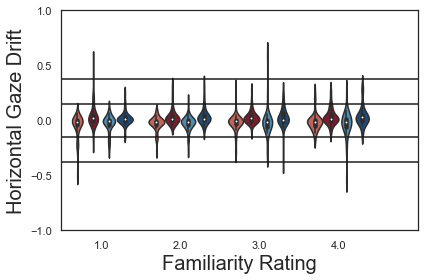

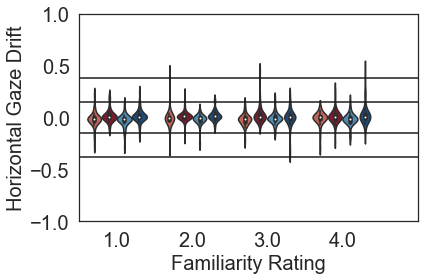

In [21]:
palette = sb.color_palette("RdBu", 20)
%matplotlib inline
gaze_mem_grp = 0

# for each experiment
for exp in ['/sustain','/variabl']:

    
    # group the data for that experiment by UniqueID, Attention Level, Familiarity Rating, Trial Type
    gaze_mem_grp = gaze_added_mem_dict[exp].groupby(['UniqueID','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    # make scaled_gaze_towards by...

    # dividing gaze_towards by half of the screen width   
    # yielding the proportional distance gazepoint is towards nearest Right/Left edge of the screen
    # (e.g. did they look "all the way" over to the Right/Left? ..."half of the way over"?)
    gaze_mem_grp['scaled_gaze_towards'] = gaze_mem_grp['gaze_towards']/(59.8/2)

    # make plots in the 'white' style
    sb.set_style('white')

    # plot scaled_gaze_towards (y axis) in terms of Attention Level (x-axis) and 
    # Familiarity Rating (grouping)
    f = sb.violinplot(x='Familiarity Rating', y='scaled_gaze_towards', 
                  data=gaze_mem_grp[(gaze_mem_grp['Attention Level']!='Novel')&
                                   (gaze_mem_grp['Trial Type']=='Memory')], hue='Attention Level',
                     palette = {"Full": palette[0], "Category": palette[3], 
                            "Side": palette[19], "None": palette[16]})

    plt.hlines(.15, xmin=-1, xmax=5) ; plt.hlines(.38, xmin=-1, xmax=5)
    plt.hlines(-.15, xmin=-1, xmax=5); plt.hlines(-.38, xmin=-1, xmax=5)

    # plot settings

    plt.grid(False)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.xlabel('Familiarity Rating',    fontsize = 20)
    plt.ylabel('Horizontal Gaze Drift', fontsize = 20)
    f.set(ylim=(-1, 1))
    f.set(xlim=(-.5, 4))
    plt.tight_layout()
    plt.legend('',frameon=False)
    plt.show()

    

#### then try with restricted data

In [22]:
behav_restricted.columns

Index(['Unnamed: 0', 'Attention Button', 'Attention Level', 'Attention Probe',
       'Attention Reaction Time (s)', 'Behavior_Image_Start', 'Category',
       'Cue Validity', 'Cued Category', 'Cued Composite', 'Cued Face',
       'Cued Place', 'Cued Side', 'Experiment', 'Familiarity Rating',
       'Familiarity Reaction Time (s)', 'Group', 'Memory Image',
       'Post Invalid Cue', 'Pre Invalid Cue', 'Rating History', 'Run',
       'Stimulus End', 'Stimulus Onset', 'Subject', 'Trial', 'Trial Type',
       'Uncued Composite', 'Uncued Face', 'Uncued Place', 'UniqueID',
       'Unnamed: 0.1', 'Unnamed: 0.1.1', 'av_x_coord', 'av_y_coord', 'avg',
       'fix', 'lefteye', 'raw', 'righteye', 'state', 'time', 'timestamp',
       'xRaw_lefteye', 'xRaw_righteye', 'yRaw_lefteye', 'yRaw_righteye',
       'gaze_from_center', 'gaze_towards_cued_side'],
      dtype='object')

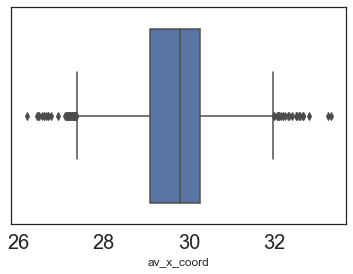

In [23]:
# check to see restricted gaze is within 4.5 of center
sb.boxplot(data = behav_restricted[behav_restricted['Trial Type']=='Presentation'], x = 'av_x_coord')

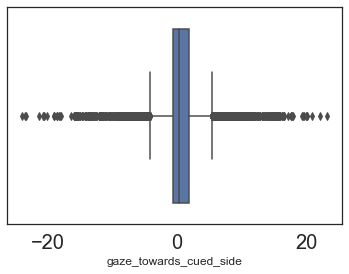

In [24]:
sb.boxplot(data = behav[behav['Trial Type']=='Presentation'], x = 'gaze_towards_cued_side')

In [25]:
gaze_added_mem_dict = {}
gaze_added_mem = []

for exp in ['/sustain','/variabl']:
    
    data = behav_restricted[behav_restricted['Experiment']==exp]

    for s in data['UniqueID'].unique():
        print(s)
        for r in data['Run'].unique():
            gaze_added_mem.append(add_gaze(data[(data['UniqueID']==s) & (data['Run']==r)]))

    gaze_mem = pd.concat(gaze_added_mem)
    gaze_mem.loc[gaze_mem['Attention Level']=='Novel','av_x_coord']=0

    gaze_mem['gaze_towards'] = gaze_mem['av_x_coord'] - (59.8/2)

    gaze_mem.loc[(gaze_mem['Cued Side']=='<') 
                 & (gaze_mem['Attention Level'].isin(['Full', 'Side'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='<') 
                                                                                                          & (gaze_mem['Attention Level'].isin(['Full', 'Side']))]['gaze_towards']

    gaze_mem.loc[(gaze_mem['Cued Side']=='>') 
                 & (gaze_mem['Attention Level'].isin(['None', 'Category'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='>') & (gaze_mem['Attention Level'].isin(['None', 'Category']))]['gaze_towards']

    gaze_mem_grp = gaze_mem.groupby(['UniqueID','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    gaze_added_mem_dict[exp] = gaze_mem

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


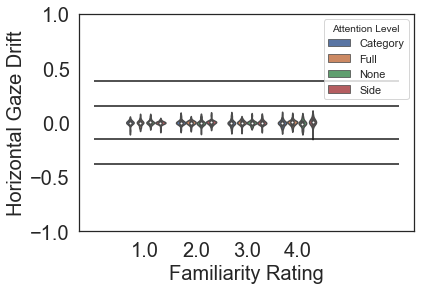

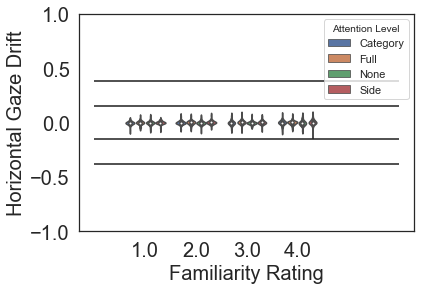

In [26]:
%matplotlib inline
for exp in ['/sustain','/variabl']:
    
    c = gaze_added_mem_dict[exp]
    gaze_mem_grp = c.groupby(['UniqueID','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    # scale by screen size
    gaze_mem_grp['scaled_gaze_towards'] = gaze_mem_grp['gaze_towards']/(59.8/2)

    # plot
    sb.set_style('white')

    f = sb.violinplot(x='Familiarity Rating', y='scaled_gaze_towards', 
                  data=gaze_mem_grp[gaze_mem_grp['Attention Level']!='Novel'], hue='Attention Level')

    plt.hlines(.15, xmin=-1, xmax=5) ; plt.hlines(.38, xmin=-1, xmax=5)
    plt.hlines(-.15, xmin=-1, xmax=5); plt.hlines(-.38, xmin=-1, xmax=5)
    
    plt.grid(False)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.xlabel('Familiarity Rating',    fontsize = 20)
    plt.ylabel('Horizontal Gaze Drift', fontsize = 20)
    f.set(ylim=(-1, 1))
    plt.show()

In [27]:
behav_restricted.to_csv('../parsed_data/behav_restricted.csv')

# Show similar results in gaze restricted data as in full dataset

### Attended Category versus Unattended

In [34]:
# group data by UniqueID, Experiment, and Attention Level
d = behav_restricted.groupby(['UniqueID', 'Experiment', 'Attention Level'], as_index=False).mean()

# for each experiment
for experiment in ['/sustain', '/variabl']:
        
    # make empty lists Cats and Nones
    Cats  = []
    Nones = []
    
    # for each participant in the select experiment
    for s in d[(d['Experiment']==experiment)]['UniqueID'].unique():
        
        # obtain the average familiarity rating this participant gave to images attended at the Category level
        # append to the list Cats
        Cats.append(d[(d['UniqueID']==s) & (d['Attention Level'].isin(['Category']) & (d['Experiment']==experiment))]['Familiarity Rating'].mean())
        
        # obtain the average familiarity rating this participant gave to images attended at the None level
        # append to the list Nones
        Nones.append(d[(d['UniqueID']==s) & (d['Attention Level']=='None') & (d['Experiment']==experiment)]['Familiarity Rating'].mean())


    print('experiment : '+experiment)
    
    # conduct a paired t-test
    print(scipy.stats.ttest_rel(Cats, Nones))
    
    print(cohen_d(Cats, Nones, repeated=True))

    print()

experiment : /sustain
Ttest_relResult(statistic=7.169020123474897, pvalue=1.399590794698858e-09)
0.9255165182281369

experiment : /variabl
Ttest_relResult(statistic=0.44040484943109437, pvalue=0.6614692782598339)
0.06049425848359282



### Attended Side versus Unattended

In [35]:
# group data by UniqueID, Experiment, and Attention Level
d = behav_restricted.groupby(['UniqueID', 'Experiment', 'Attention Level'], as_index=False).mean()

# for each experiment
for experiment in ['/sustain', '/variabl']:
    
    # make empty lists Sides and Nones
    Sides  = []
    Nones = []
    
    # for each participant in the select experiment
    for s in d[(d['Experiment']==experiment)]['UniqueID'].unique():

        # obtain the average familiarity rating this participant gave to images attended at the Side level
        # append to the list Sides
        Sides.append(d[(d['UniqueID']==s) & (d['Attention Level'].isin(['Side'])) & (d['Experiment']==experiment)]['Familiarity Rating'].mean())
        
        # obtain the average familiarity rating this participant gave to images attended at the None level
        # append to the list Nones
        Nones.append(d[(d['UniqueID']==s) & (d['Attention Level']=='None') & (d['Experiment']==experiment)]['Familiarity Rating'].mean())

    # conduct a paired t-test
    print(scipy.stats.ttest_rel(Sides, Nones))
    print(cohen_d(Sides, Nones, repeated=True))
    print()

Ttest_relResult(statistic=4.320885072719229, pvalue=6.048927164309282e-05)
0.5578238642505925

Ttest_relResult(statistic=2.5698125574654336, pvalue=0.01308094028631331)
0.3529909021358748



In [30]:
######################################################